In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import statsmodels.api as sm
import seaborn as sns

from statsmodels.regression.linear_model import OLS

sns.set(rc = {"figure.figsize":(16, 16)})

In [49]:
def df_OLS_anal(df: pd.DataFrame, mode = 0):
    if(mode == 0):
        deltaA = np.array(df["AskAfter"] - df["AskBefore"])[1:-1]
    else:
        deltaA = np.array(df["AskAfterMany"] - df["AskBeforeMany"])[1:-1]

    deltat = np.array(np.diff(df["Time"]))[1:]
    x = np.array(df["Volume"][1:-1])

    dA = np.array(deltaA / deltat)
    dx = np.array(x / deltat)
    ddx = np.array(np.diff(dx))
    ddA = np.array(np.diff(dA))

    OLSdf = pd.DataFrame({
        "SUM": ddA,
        "-rho": deltaA[:-1],
        "-rho kappa": x[1:],
        "rho (lambda + kappa)": x[:-1],
        "kappa + lambda": ddx
    })

    Regressand = OLSdf["SUM"]

    Regressors = OLSdf[["-rho", "-rho kappa", "rho (lambda + kappa)", "kappa + lambda"]]


    # Regressors = sm.add_constant(Regressors, prepend=False)

    model = OLS(Regressand, Regressors)

    res = model.fit()

    print(res.summary()) 

    # print(res.bse[0])

    rho = - res.params.iloc[0]
    kappa = - res.params.iloc[1] / rho
    lamb = res.params.iloc[2] / rho - kappa
    # lamb2 = res.params.iloc[3] - kappa
    

    print("rho = ", rho, "\nlambda = ", lamb, "\nkappa = ", kappa, "\n \n", end="")

    return rho, kappa, lamb, res.bse.iloc[0]


In [50]:
def df_OLS_anal2(df: pd.DataFrame, mode = 0):
    if(mode == 0):
        deltaA = np.array(df["AskAfter"] - df["AskBefore"])[1:-1]
    else:
        deltaA = np.array(df["AskAfterMany"] - df["AskBeforeMany"])[1:-1]
        
    deltat = np.array(np.diff(df["Time"]))[1:]
    x = np.array(df["Volume"][1:-1])

    dA = np.array(deltaA / deltat)
    dx = np.array(x / deltat)
    ddx = np.array(np.diff(dx))
    ddA = np.array(np.diff(dA))

    OLSdf = pd.DataFrame({
        "SUM": ddA,
        "-rho": deltaA[:-1],
        "-rho kappa": np.diff(x),
        "rho lambda": x[:-1],
        "kappa + lambda": ddx
    })

    Regressand = OLSdf["SUM"]

    Regressors = OLSdf[["-rho", "-rho kappa", "rho lambda", "kappa + lambda"]]


    # Regressors = sm.add_constant(Regressors, prepend=False)

    model = OLS(Regressand, Regressors)

    res = model.fit()

    print(res.summary()) 

    rho = - res.params.iloc[0]
    kappa = - res.params.iloc[1] / rho
    lamb = res.params.iloc[2] / rho - kappa
    # lamb2 = res.params.iloc[3] - kappa
    

    print("rho = ", rho, "\nlambda = ", lamb, "\nkappa = ", kappa, "\n \n", end="")

    return rho, kappa, lamb, res.bse.iloc[0]

In [12]:
def df_OLS_anal3(df: pd.DataFrame, mode = 0):
    if(mode == 0):
        deltaA = np.array(df["AskAfter"] - df["AskBefore"])[1:-1]
    else:
        deltaA = np.array(df["AskAfterMany"] - df["AskBeforeMany"])[1:-1]
        
    deltat = np.array(np.diff(df["Time"]))[1:]
    x = np.array(df["Volume"][1:-1])

    dA = np.array(deltaA / deltat)
    dx = np.array(x / deltat)
    ddx = np.array(np.diff(dx))
    ddA = np.array(np.diff(dA))

    dummy_first = np.array((df["Time"] < 3600)[1:-2], dtype=float)
    dummy_last = np.array((df["Time"] > 27500)[1:-2], dtype=float)

    OLSdf = pd.DataFrame({
        "SUM": ddA,
        "-rho": deltaA[:-1],
        "-rho kappa": x[1:],
        "rho (lambda + kappa)": x[:-1],
        "kappa + lambda": ddx,
        "first hour": dummy_first,
        "last hour": dummy_last
    })

    Regressand = OLSdf["SUM"]

    Regressors = OLSdf[["-rho", "-rho kappa", "rho (lambda + kappa)", "kappa + lambda","first hour", "last hour" ]]


    # Regressors = sm.add_constant(Regressors, prepend=False)

    model = OLS(Regressand, Regressors)

    res = model.fit()

    print(res.summary()) 

    rho = - res.params.iloc[0]
    kappa = - res.params.iloc[1] / rho
    lamb = res.params.iloc[2] / rho - kappa
    # lamb2 = res.params.iloc[3] - kappa
    

    print("rho = ", rho, "\nlambda = ", lamb, "\nkappa = ", kappa, "\n \n", end="")

    return rho, kappa, lamb


In [69]:
directory = "data/SE/"
 
files = os.listdir(directory)

listQuadras = []

for file in files:
    if(file.endswith(".csv")):
        print("data/"+file)
        df = pd.read_csv(directory + file)
        total = len(df)
        lil = len(df[df["AskAfter"] - df["AskBefore"] <=0 ])
        me = np.mean(df["Volume"])
        spikes = len(df[((df["AskAfter"] - df["AskBefore"] > 0) & (df["Volume"] < me))])

        max = len(df)
        for index, row in df.iterrows():
            if index < max - 1 and abs(df.loc[index, 'Time'] - df.loc[index + 1, 'Time']) < 1e-3:
                # print(index)
                df.loc[index + 1, 'Volume'] = df.loc[index + 1, 'Volume'] + df.loc[index, 'Volume']
                df.loc[index + 1, 'AskBefore'] = df.loc[index, 'AskBefore']
                df = df.drop([index])

        df = df.reset_index()
        df = df.drop(["index"], axis=1)

        rho, kappa, lambd, se =    df_OLS_anal(df)
        rho1, kappa1, lambd1, se1 = df_OLS_anal2(df, 1)

        vol = sum(df["Volume"])

        pr = sum(df["Volume"] * df["AskBefore"])
                  
        listQuadras.append(np.array(
            [
            file[:-6]
            ,total
            ,vol
            ,pr
            ,lil
            # ,spikes
            # ,me * 1e1
            , lil/total
            , spikes/(total - lil)
            , rho
            , se
            , rho1
            , se1
            ]
            # len(df[df["AskAfter"] - df["AskBefore"] <= 0  & df["Volume"] > 1e5])
            ))

listQuadras.sort(key=lambda x: int(x[1]))
print(listQuadras)

data/GAZPWP.csv
                                 OLS Regression Results                                
Dep. Variable:                    SUM   R-squared (uncentered):                   0.457
Model:                            OLS   Adj. R-squared (uncentered):              0.457
Method:                 Least Squares   F-statistic:                              2526.
Date:                Wed, 31 Jan 2024   Prob (F-statistic):                        0.00
Time:                        19:20:23   Log-Likelihood:                         -8410.0
No. Observations:               11994   AIC:                                  1.683e+04
Df Residuals:                   11990   BIC:                                  1.686e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------

In [77]:
# from math import round
listQuadras.sort(key=lambda x: float(x[1]))
for q in listQuadras[::-1]:
    l = np.array([q[0]
                #   ,round(float(q[1] ))
                #   ,round(float(q[2] ))
                #   ,round(float(q[3] ))
                #   ,round(float(q[-4]) * 100) 
                #   ,round(float(q[-2]))
                #   ,round(float(q[-1])) 
                  ,round(float(q[-4]), 4)
                  ,round(float(q[-3]), 4)
                  ,round(float(q[-2]), 4)
                  ,round(float(q[-1]), 4)
                     ])
    an = ""
    i = 0
    for num in l:
        if i == 0:
            an += (num + " & $")
            i =1
            continue
        an += '%.3e' % float(num)
        an += "$ & $"
    an += " \\\\ \hline"
    print(" & ".join(l) +" \\\\ \hline")
    # print(an)

SBER & 0.7744 & 0.0063 & 0.9337 & 0.0072 \\ \hline
GAZP & 0.8641 & 0.0086 & 0.7051 & 0.0082 \\ \hline
YNDX & 0.773 & 0.0095 & 0.435 & 0.0072 \\ \hline
MGNT & 0.7336 & 0.0113 & 0.4186 & 0.0095 \\ \hline
LKOH & 0.4757 & 0.0078 & 0.433 & 0.009 \\ \hline
ROSN & 0.3116 & 0.0076 & 0.7418 & 0.012 \\ \hline
PLZL & 0.2234 & 0.0056 & 0.4871 & 0.0122 \\ \hline
SNGSP & 0.1842 & 0.0084 & 0.3528 & 0.0099 \\ \hline
MTLR & 0.5591 & 0.0092 & 0.5574 & 0.0112 \\ \hline


In [67]:
# from math import round
listQuadras.sort(key=lambda x: float(x[3]))
for q in listQuadras[::-1]:
    l = np.array([q[0]
                  # ,round(float(q[1] ))
                  # ,round(float(q[2] ))
                  # ,round(float(q[3] ))
                #   ,round(float(q[-4]) * 100) 
                #   ,round(float(q[-2]))
                #   ,round(float(q[-1])) 
                  ,round(float(q[-4]), 4)
                  ,round(float(q[-3]), 4)
                  ,round(float(q[-2]), 4)
                  ,round(float(q[-1]), 4)
                     ])
    an = ""
    i = 0
    for num in l:
        if i == 0:
            an += (num + " & $")
            i =1
            continue
        an += '%.3e' % float(num)
        an += "$ & $"
    an += " \\\\ \hline"
    print(" & ".join(l) +" \\\\ \hline")
    # print(an)

SBER & 0.7744 & 0.0063 & 0.9337 & 0.0072 \\ \hline
GAZP & 0.8641 & 0.0086 & 0.7051 & 0.0082 \\ \hline
LKOH & 0.4757 & 0.0078 & 0.433 & 0.009 \\ \hline
YNDX & 0.773 & 0.0095 & 0.435 & 0.0072 \\ \hline
PLZL & 0.2234 & 0.0056 & 0.4871 & 0.0122 \\ \hline
ROSN & 0.3116 & 0.0076 & 0.7418 & 0.012 \\ \hline
MGNT & 0.7336 & 0.0113 & 0.4186 & 0.0095 \\ \hline
SNGSP & 0.1842 & 0.0084 & 0.3528 & 0.0099 \\ \hline
MTLR & 0.5591 & 0.0092 & 0.5574 & 0.0112 \\ \hline


In [ ]:
y = 1
def f(x):
    x - x * np.log(x) + np.exp(-y / x) + y - 2

In [2]:
def solve_eq(f, a, b, delta=0.001):
    
    y_a = f(a)
    y_b =  f(b)
    direction = f(b) - f(a)
    
    if not y_a*y_b<0:
        print("нарушены условия разных знаков точек")
        return None
    
    dif = b-a       
    while dif>delta:
        # import pdb; pdb.set_trace()
        c = a+(b-a)/2
        y = f(c)
        if y==0:
            return c
        if y*direction > 0:
            b=c
        else:
            a = c
        dif = b-a
        
    return b

/tmp/ipykernel_45182/528316293.py:2: RuntimeWarning: divide by zero encountered in log
  return x - x * np.log(x) + np.exp(-y / x) + y - 2
/tmp/ipykernel_45182/528316293.py:2: RuntimeWarning: invalid value encountered in multiply
  return x - x * np.log(x) + np.exp(-y / x) + y - 2
/tmp/ipykernel_45182/528316293.py:2: RuntimeWarning: divide by zero encountered in divide
  return x - x * np.log(x) + np.exp(-y / x) + y - 2
/tmp/ipykernel_45182/528316293.py:2: RuntimeWarning: invalid value encountered in divide
  return x - x * np.log(x) + np.exp(-y / x) + y - 2


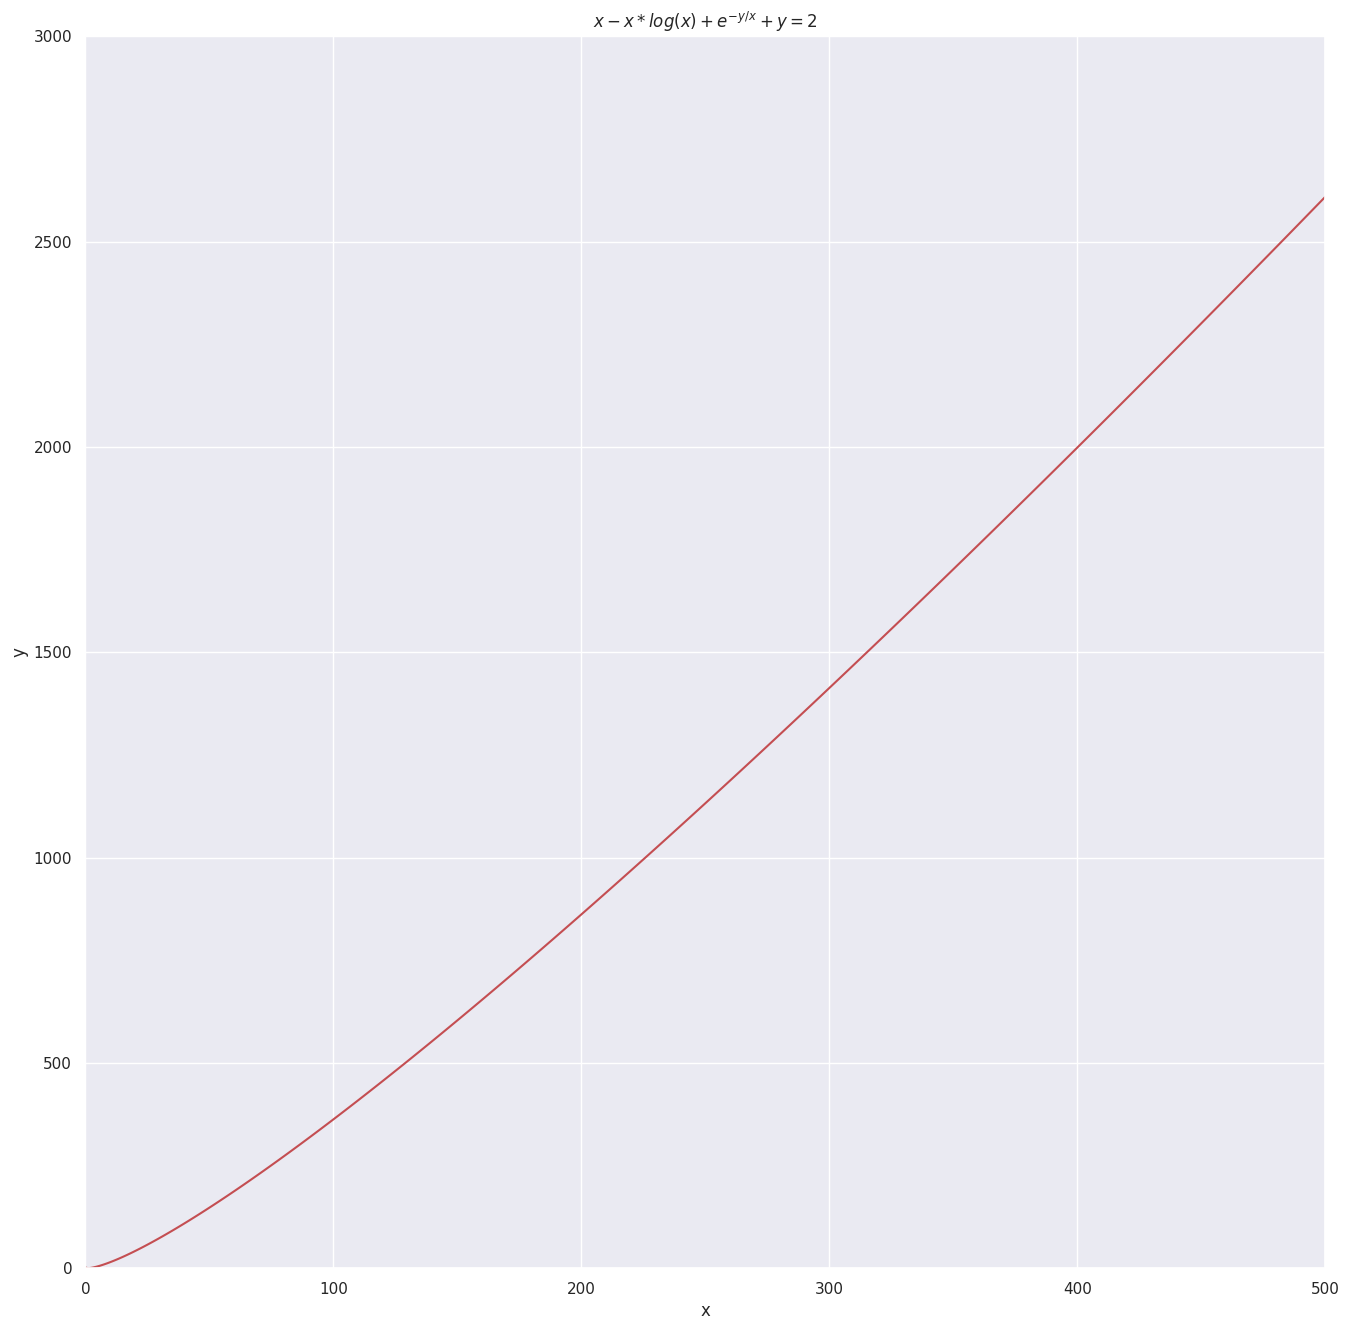

In [5]:
def implicit_function(x, y):
    return x - x * np.log(x) + np.exp(-y / x) + y - 2
    # return x**2 + y**2 - 3

x = np.linspace(0, 500, 5000)
y = np.linspace(0, 3000, 5000)
# x = np.linspace(-2, 2, 10)
# y = np.linspace(-2, 2, 10)
X, Y = np.meshgrid(x, y)

Z = implicit_function(X, Y)

plt.contour(X, Y, Z, levels=[0], colors='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r"$x - x * log(x) + e^{-y/x} + y = 2$")
plt.savefig("tBy.pdf")
plt.show()


/tmp/ipykernel_45182/3659378583.py:2: RuntimeWarning: divide by zero encountered in log
  return x - x * np.log(x) + np.exp(-y ) + x*y - 2
/tmp/ipykernel_45182/3659378583.py:2: RuntimeWarning: invalid value encountered in multiply
  return x - x * np.log(x) + np.exp(-y ) + x*y - 2


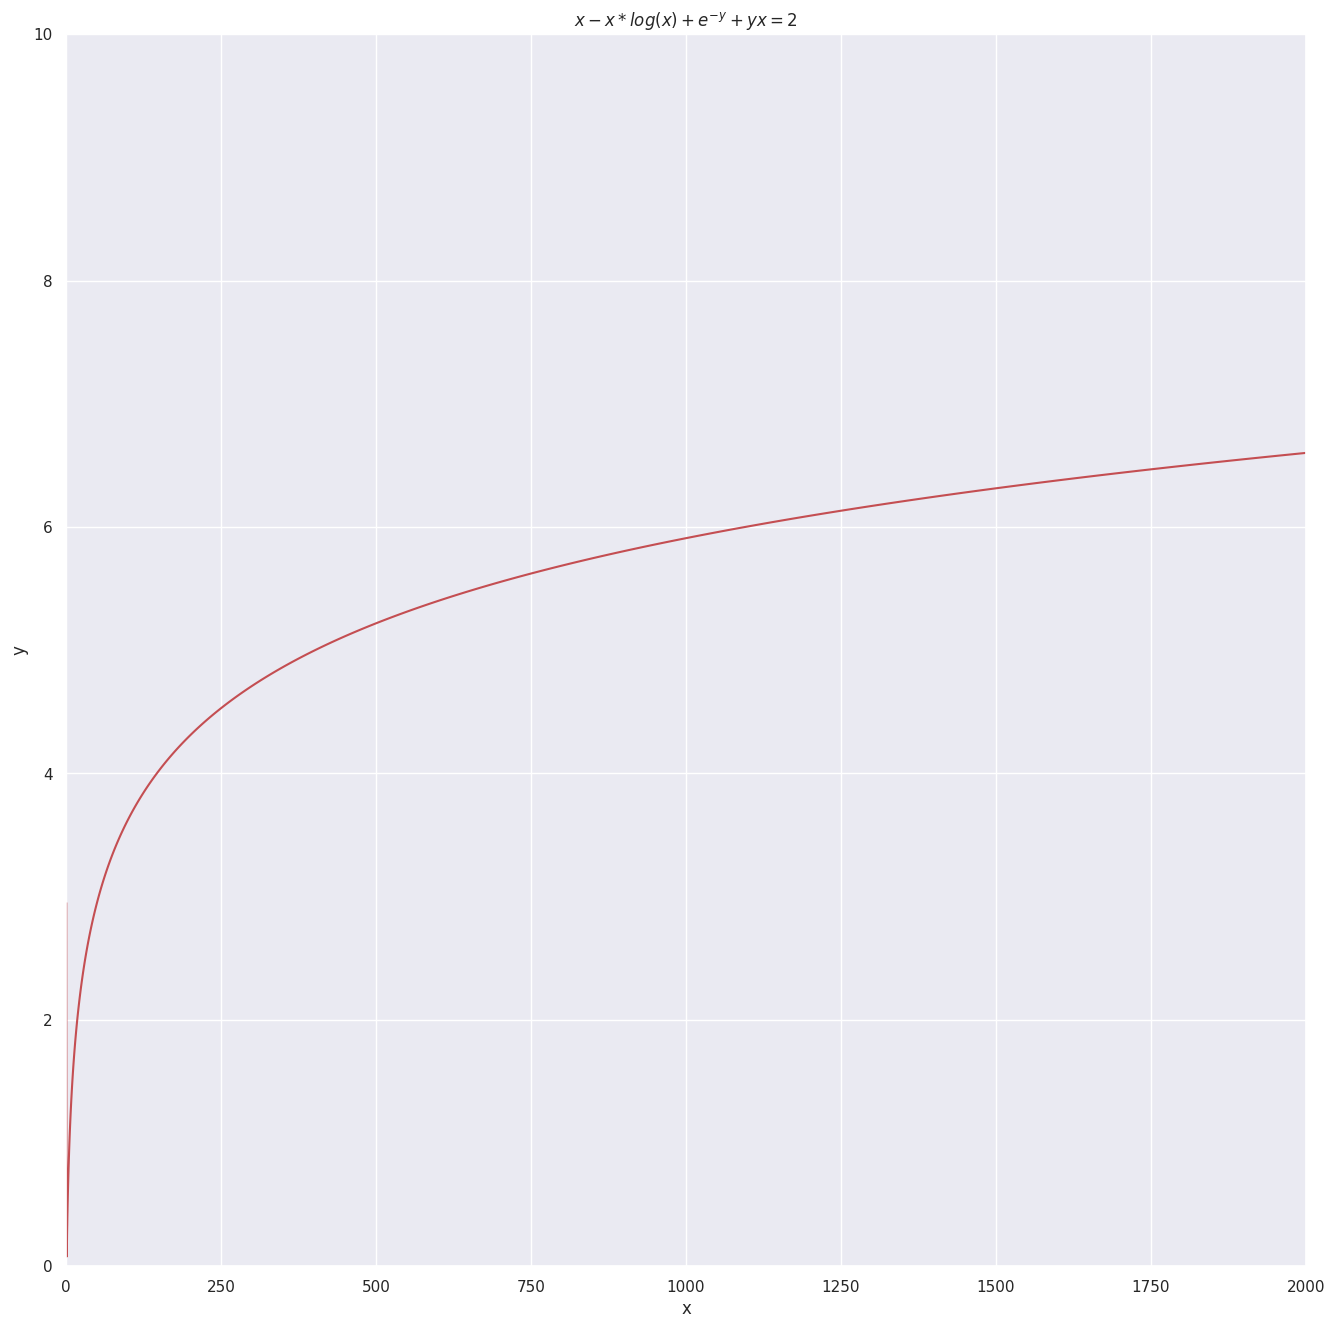

In [7]:
def implicit_function(x, y):
    return x - x * np.log(x) + np.exp(-y ) + x*y - 2
    # return x**2 + y**2 - 3

x = np.linspace(0, 2000, 5000)
y = np.linspace(0, 10, 5000)
# x = np.linspace(-2, 2, 10)
# y = np.linspace(-2, 2, 10)
X, Y = np.meshgrid(x, y)

Z = implicit_function(X, Y)

plt.contour(X, Y, Z, levels=[0], colors='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r"$x - x * log(x) + e^{-y} + yx = 2$")
plt.savefig("trhoy.pdf")
plt.show()

In [17]:
y = 10
solve_eq(EqGen(y), 0.01, 100)

0.1557068634033203

In [4]:
f = lambda x: x**2 - 2

print(solve_eq(f,0, 5))

1.414794921875


In [21]:
directory = "data/CU/03.03.2021/"
 
files = os.listdir(directory)

listQuadras = []

for file in files:
    if(file.endswith(".csv")):
        print("data/"+file)
        df = pd.read_csv(directory + file)
        total = len(df)
        lil = len(df[df["AskAfter"] - df["AskBefore"] <=0 ])
        me = np.mean(df["Volume"])
        spikes = len(df[((df["AskAfter"] - df["AskBefore"] > 0) & (df["Volume"] < me))])

        max = len(df)
        for index, row in df.iterrows():
            if index < max - 1 and abs(df.loc[index, 'Time'] - df.loc[index + 1, 'Time']) < 1e-3:
                # print(index)
                df.loc[index + 1, 'Volume'] = df.loc[index + 1, 'Volume'] + df.loc[index, 'Volume']
                df.loc[index + 1, 'AskBefore'] = df.loc[index, 'AskBefore']
                df = df.drop([index])

        df = df.reset_index()
        df = df.drop(["index"], axis=1)

        rho, kappa, lambd =    df_OLS_anal2(df)
        rho1, kappa1, lambd1 = df_OLS_anal2(df, 1)
                  
        listQuadras.append(np.array(
            [
            file[:-6]
            ,total
            ,lil
            # ,spikes
            # ,me * 1e1
            , lil/total
            , spikes/(total - lil)
            , rho
            , rho1
            ]
            # len(df[df["AskAfter"] - df["AskBefore"] <= 0  & df["Volume"] > 1e5])
            ))

listQuadras.sort(key=lambda x: int(x[1]))
print(listQuadras)

data/EUR_RUB__TODWP.csv
                                 OLS Regression Results                                
Dep. Variable:                    SUM   R-squared (uncentered):                   0.357
Model:                            OLS   Adj. R-squared (uncentered):              0.356
Method:                 Least Squares   F-statistic:                              297.9
Date:                Wed, 31 Jan 2024   Prob (F-statistic):                   5.89e-204
Time:                        14:43:22   Log-Likelihood:                          7615.3
No. Observations:                2149   AIC:                                 -1.522e+04
Df Residuals:                    2145   BIC:                                 -1.520e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [22]:
# from math import round
for q in listQuadras[::-1]:
    l = np.array([q[0]
                  ,round(float(q[1] ))
                #   ,round(float(q[-4]) * 100) 
                #   ,round(float(q[-2]))
                #   ,round(float(q[-1])) 
                  ,float(q[-2])
                  ,float(q[-1])
                     ])
    print(" & ".join(l) +" \\\\ \hline")
    # print(q)

USD000UTSTOM & 28361 & 0.4586605825254843 & 0.5992651640825155 \\ \hline
USD000000TOD & 9624 & 0.1988686390027684 & 0.16090594730894867 \\ \hline
EUR_RUB__TOM & 4021 & 0.2326587382094915 & 0.1493696053845097 \\ \hline
EUR_RUB__TOD & 2535 & 0.1932051710115114 & 0.2267376927870456 \\ \hline
CNYRUB_TOM & 371 & 0.03590525456327961 & 0.010948875773766412 \\ \hline
GBPRUB_TOM & 220 & 0.01454917489907815 & 0.002305257888834277 \\ \hline
CNY000000TOD & 55 & 0.056243043529142986 & 0.13524851802804994 \\ \hline
GBPRUB_TOD & 38 & -0.061153208531235986 & 0.08165224510375016 \\ \hline


In [20]:
# from math import round
for q in listQuadras[::-1]:
    l = np.array([q[0]
                  ,round(float(q[1] ))
                #   ,round(float(q[-4]) * 100) 
                #   ,round(float(q[-2]))
                #   ,round(float(q[-1])) 
                  ,float(q[-2])
                  ,float(q[-1])
                     ])
    print(" & ".join(l) +" \\\\ \hline")
    # print(q)

SBER & 41647 & 0.7744344526714689 & 0.9336615609694938 \\ \hline
GAZP & 21566 & 0.8641382257087411 & 0.7051375433171672 \\ \hline
YNDX & 14110 & 0.7730476663943415 & 0.43498574866808637 \\ \hline
MGNT & 10929 & 0.7336485623556505 & 0.4186110571211804 \\ \hline
LKOH & 9759 & 0.47568476053662856 & 0.433018847613565 \\ \hline
ROSN & 8648 & 0.31162753257572134 & 0.7418400236051489 \\ \hline
PLZL & 7121 & 0.22340999111775306 & 0.48711118227005584 \\ \hline
SNGSP & 6032 & 0.18422203706510934 & 0.3528138941550399 \\ \hline
MTLR & 5985 & 0.5590564289428172 & 0.557367760116171 \\ \hline


In [35]:
df = pd.read_csv("data/CU/2020/USD000000TODWP.csv")

In [45]:
df = df[df["AskAfter"] - df["AskBefore"] > 0]

In [46]:
w_len = 100

ms = sum(np.diff(df["Time"])[0:w_len])
j_best = 0

for i in range(len(df) - w_len):
    ns = sum(np.diff(df["Time"])[i:i+w_len])
    if ns < ms:
        j_best = i

print(j_best)

print(ms / w_len)
print(np.min(np.diff(df["Time"])[j_best:j_best+w_len]))

1506
0.5499998674100062
1.0310031939297915e-06


In [115]:
for q in listQuadras[::-1]:
    l = np.array((q[0], q[1], q[-1], q[-2]))
    print(" & ".join(l) +" \\\\ \hline")

USD000UTSTOM & 41963 & -1.3454038118541596e-13 & -3.9993134823310335e-13 \\ \hline
USD000000TOD & 13391 & 3.953096901572806e-13 & 878971.6190915223 \\ \hline
EUR_RUB__TOM & 13383 & -1.6103787588652537e-13 & 149030.37989297457 \\ \hline
EUR_RUB__TOD & 4134 & -2.8968832214492e-11 & 100550.84664241684 \\ \hline
USD000TODTOM & 1343 & -3.4403061472022886e-17 & 1.881472333580073e-16 \\ \hline
EURUSD000TOM & 915 & -1.8793893072248073e-13 & -1.1984356617419773e-14 \\ \hline
EUR000TODTOM & 265 & 3.346062887920089e-18 & 225006.73004700168 \\ \hline
GBPRUB_TOM & 234 & 0.318196286111428 & -0.7899878452418242 \\ \hline
CNYRUB_TOM & 167 & 5.040051784091274e-13 & 6.186202700324166e-14 \\ \hline


In [15]:
df = pd.read_csv("data/SE/LKOHWP.csv")
max = len(df)
for index, row in df.iterrows():
    if index < max - 1 and abs(df.loc[index, 'Time'] - df.loc[index + 1, 'Time']) < 1e-3:
        # print(index)
        df.loc[index + 1, 'Volume'] = df.loc[index + 1, 'Volume'] + df.loc[index, 'Volume']
        df.loc[index + 1, 'AskBefore'] = df.loc[index, 'AskBefore']
        df = df.drop([index])

df = df.reset_index()
df = df.drop(["index"], axis=1)

# dts = np.diff(df["Time"])
# plt.hist(dts[dts < 0.2])

df_OLS_anal2(df)

                                 OLS Regression Results                                
Dep. Variable:                    SUM   R-squared (uncentered):                   0.365
Model:                            OLS   Adj. R-squared (uncentered):              0.364
Method:                 Least Squares   F-statistic:                              927.2
Date:                Wed, 31 Jan 2024   Prob (F-statistic):                        0.00
Time:                        14:20:14   Log-Likelihood:                         -19320.
No. Observations:                6461   AIC:                                  3.865e+04
Df Residuals:                    6457   BIC:                                  3.868e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

(0.47568476053662856, 0.00040623238430674796, 0.0007026829908844234)

In [3]:
dts = np.diff(df["Time"])

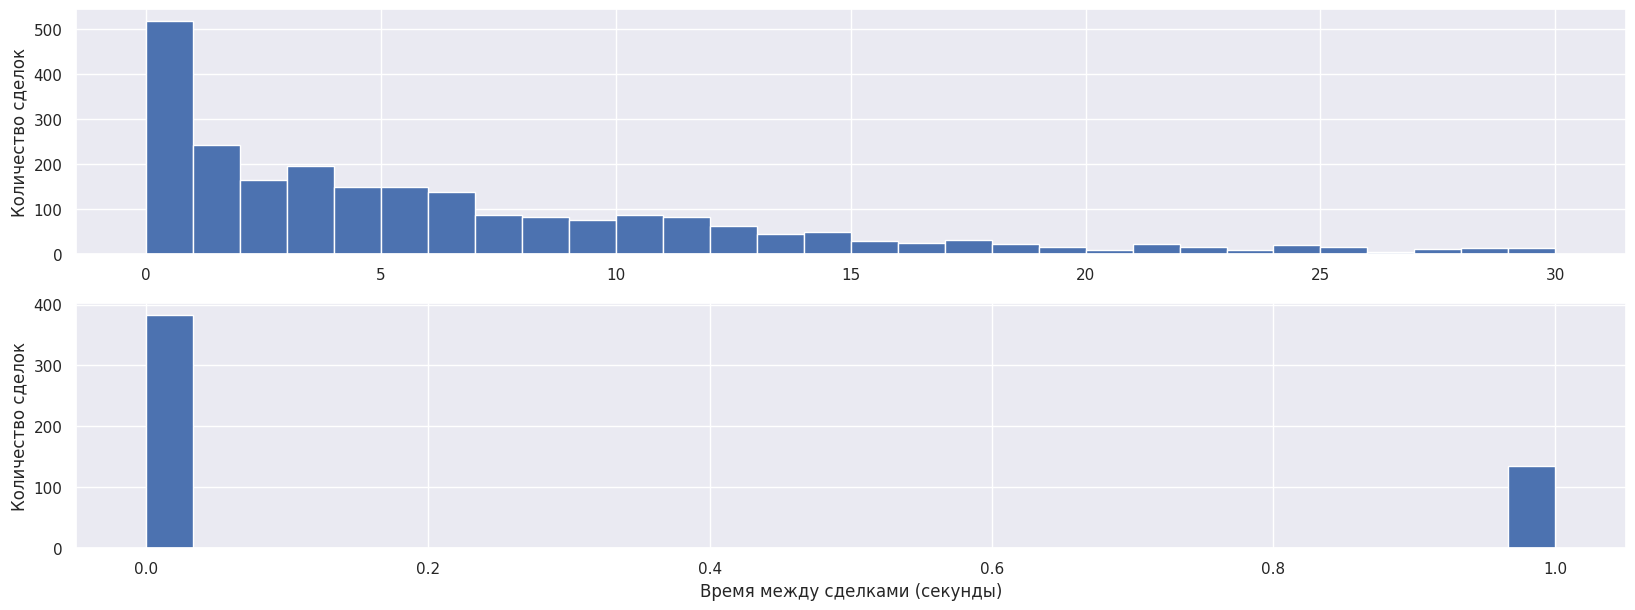

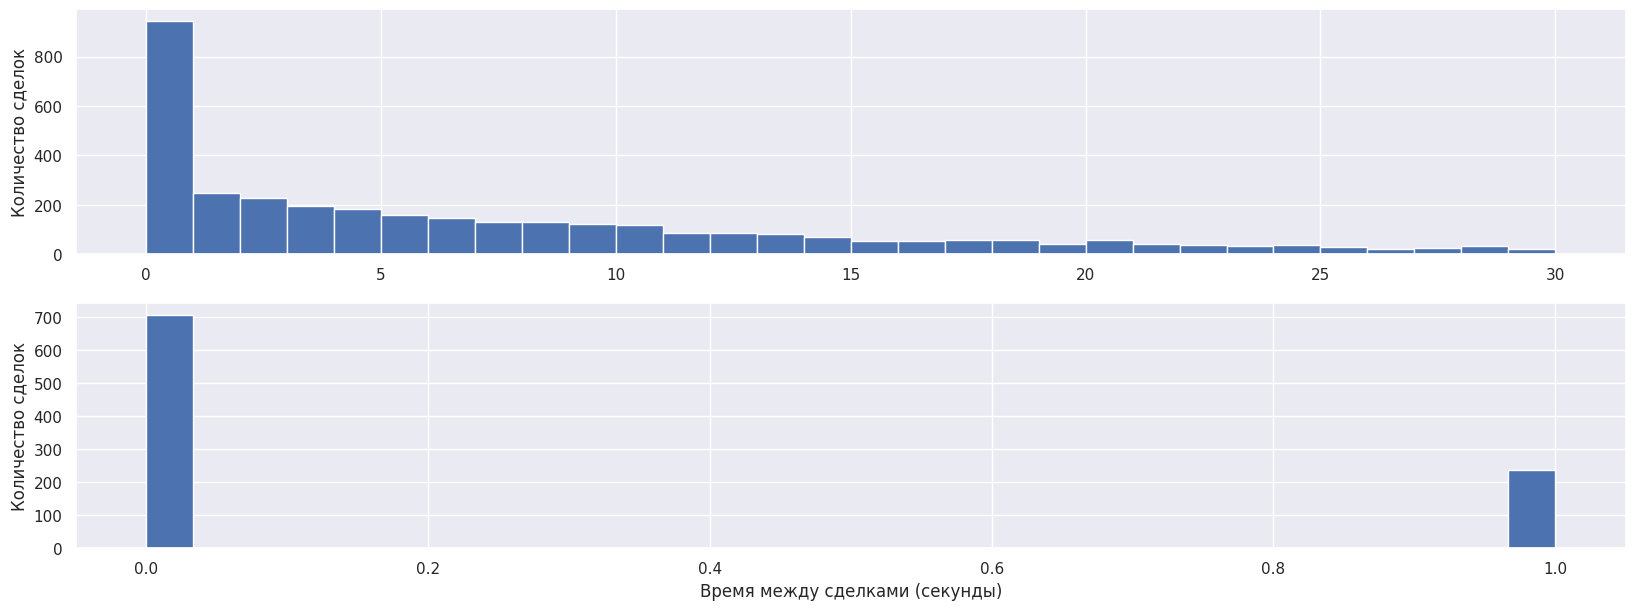

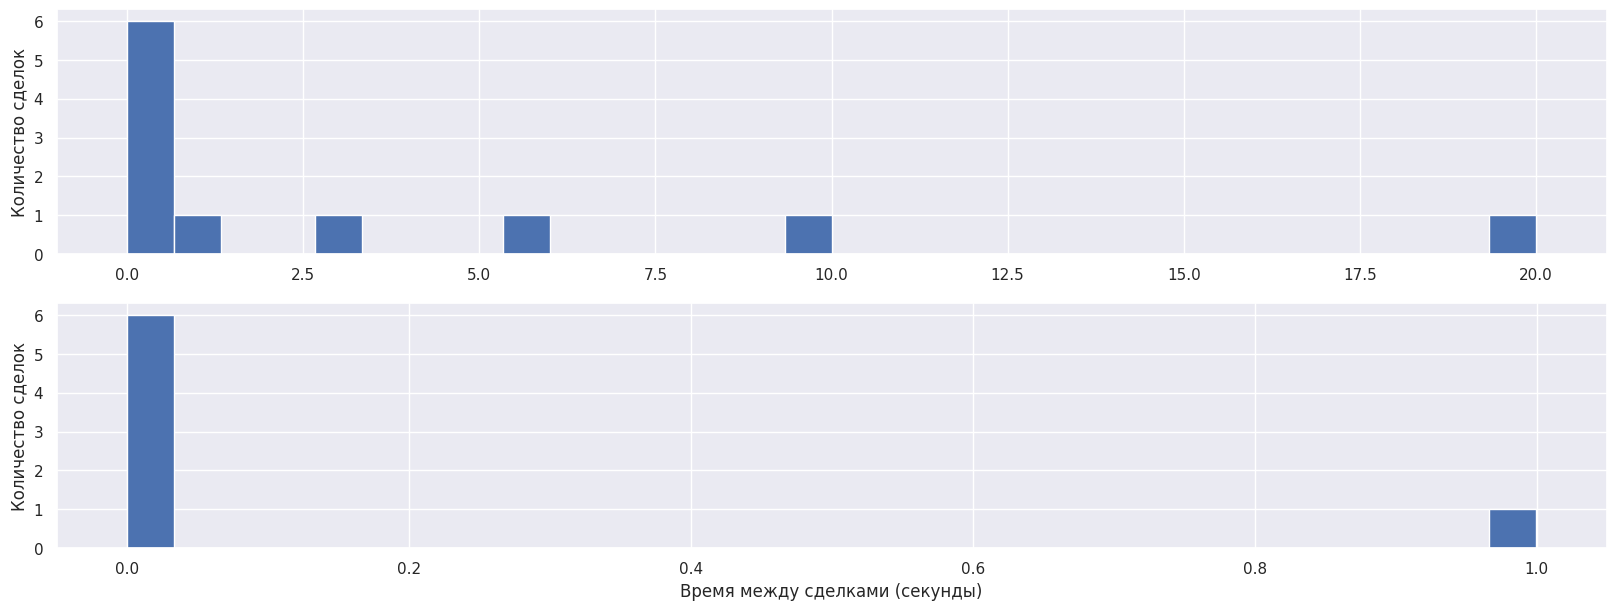

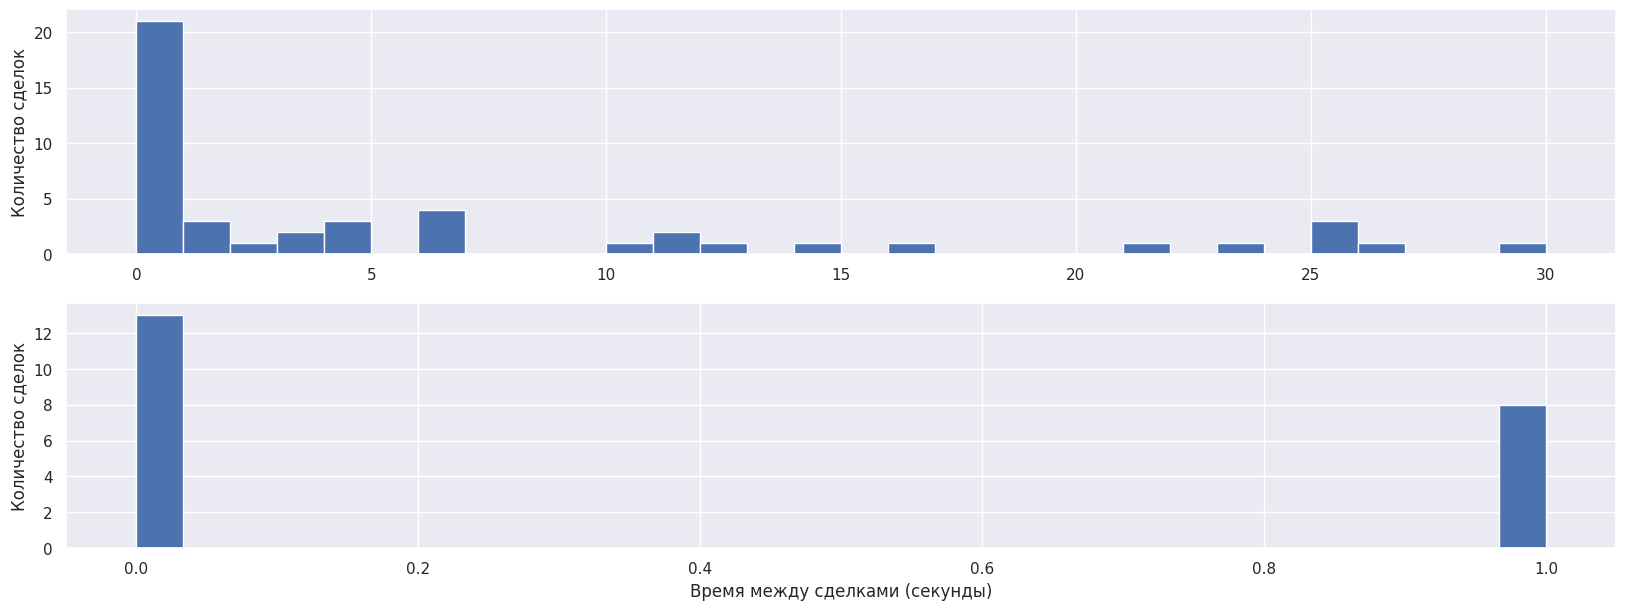

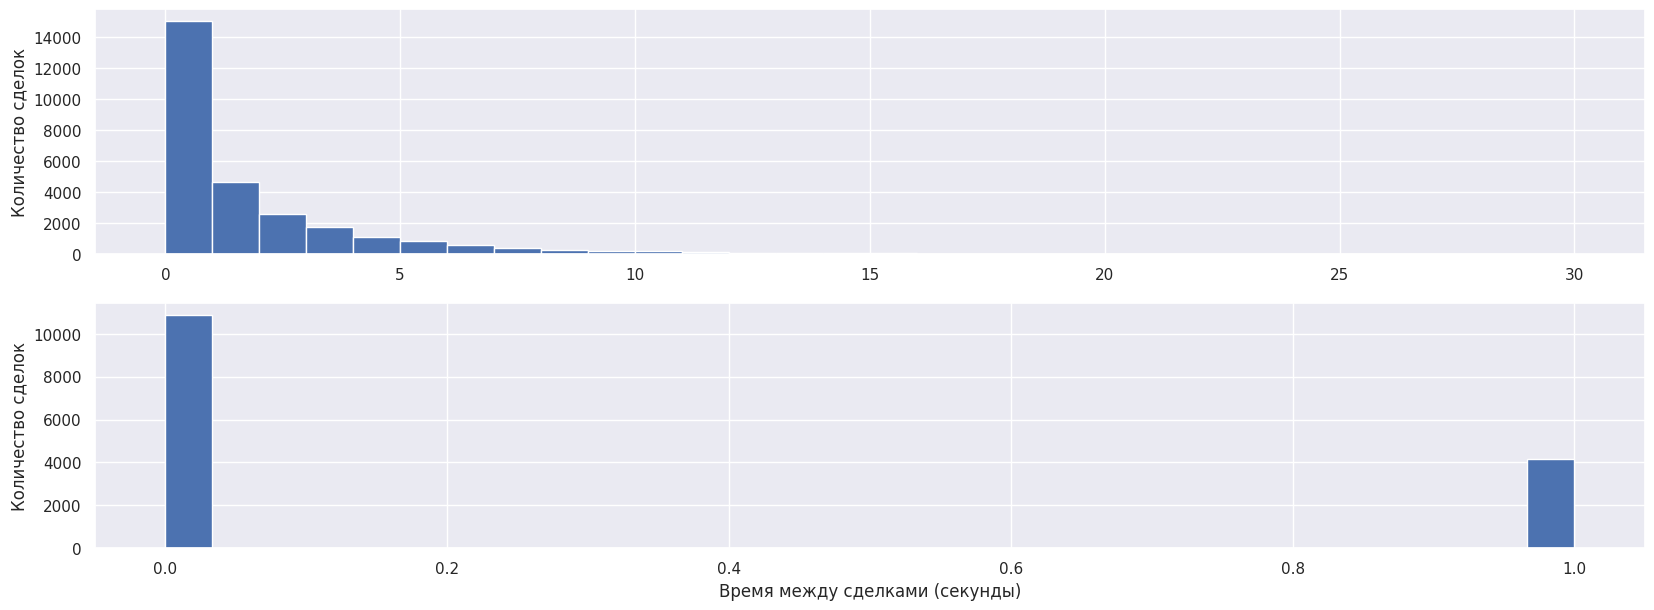

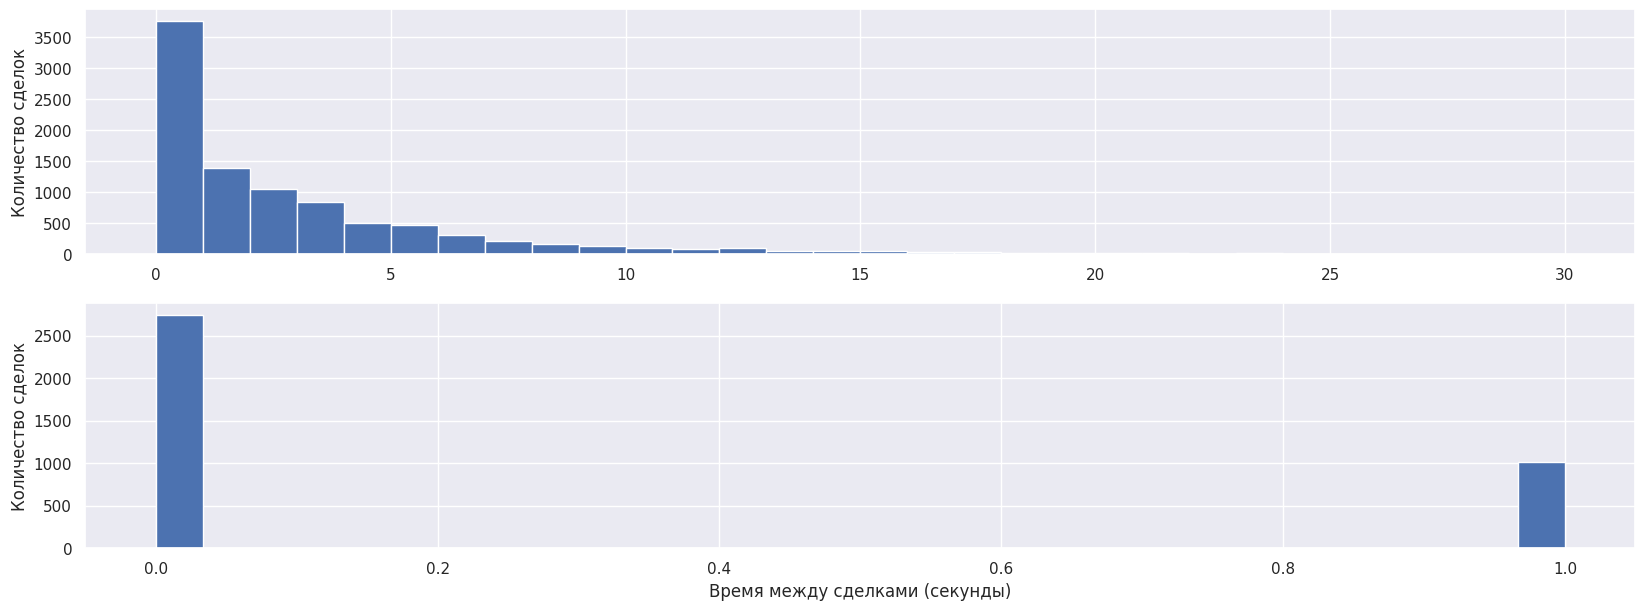

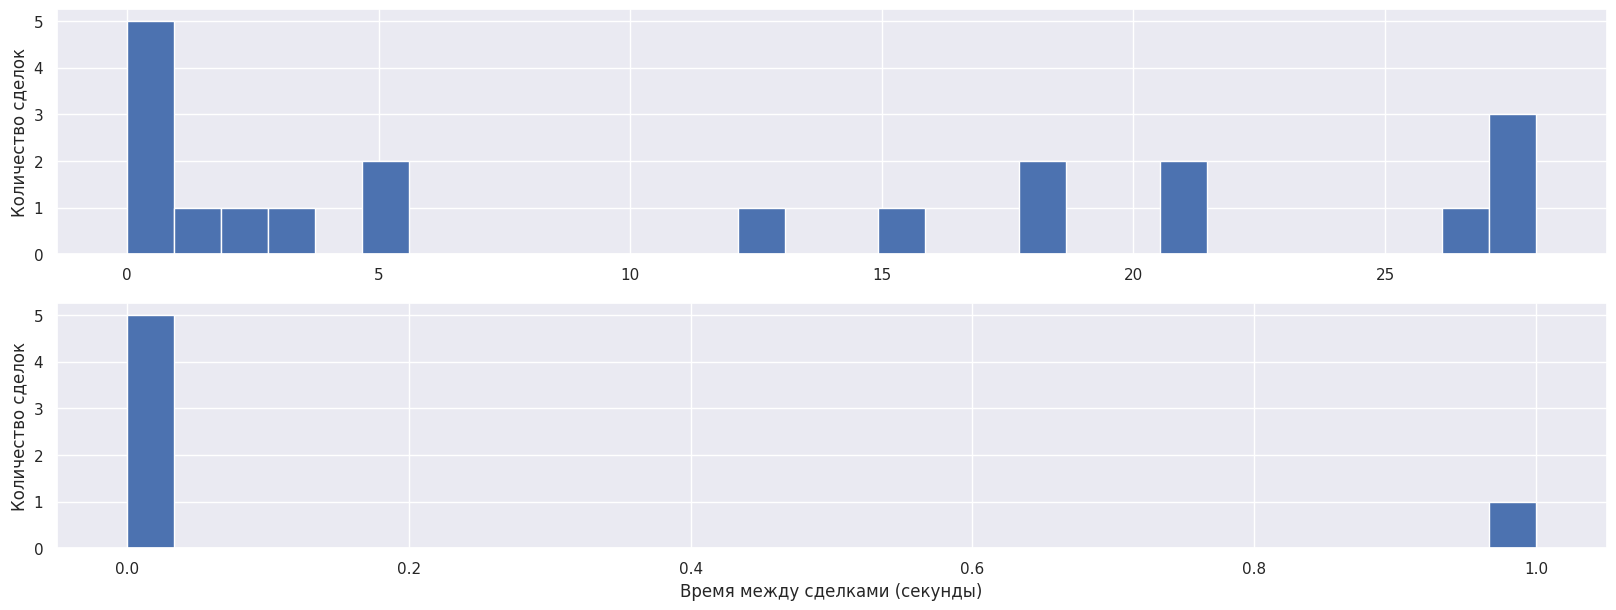

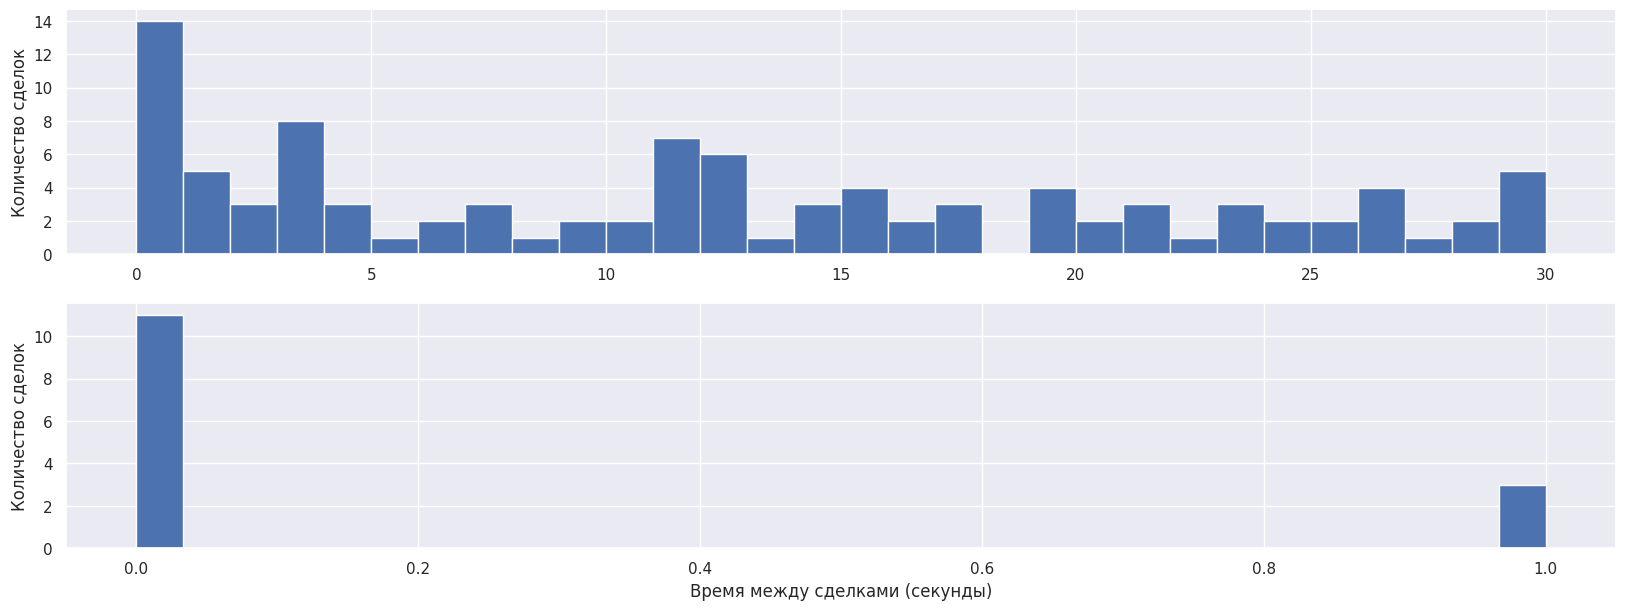

In [49]:
sns.set(rc = {"figure.figsize":(20, 7)})
directory = "data/CU/03.03.2021/"
 
files = os.listdir(directory)

listQuadras = []

for file in files:
    if(file.endswith(".csv")):
        # print("data/"+file)
        df = pd.read_csv(directory + file)
        fig, axs = plt.subplots(nrows= 2, ncols= 1 )
        dts = np.diff(df["Time"])

        #add title
        # fig. suptitle('Распределение времени между соседними ордерами для ' + file[:-4])

        axs[0].hist(dts[dts < 30], bins=30)
        axs[0].set_ylabel("Количество сделок")
        axs[1].hist(dts[dts < 1], bins=30)

        plt.xlabel("Время между сделками (секунды)")
        plt.ylabel("Количество сделок")
        plt.savefig(file[:-6] + ".pdf")

In [58]:
dummy_first = np.array((df["Time"] < 3600)[1:-2], dtype=float)
print(dummy_first)

[1. 1. 1. ... 0. 0. 0.]


In [19]:
len(df[df["AskAfter"] - df["AskBefore"] > 0])

2250

In [20]:
len(df)

41963

In [80]:
def df_OLS_anal_AO(df: pd.DataFrame):
    deltaA = np.array(df["AskAfter"] - df["AskBefore"])[1:-1]
    deltat = np.array(np.diff(df["Time"]))[1:]
    x = np.array(df["Volume"][1:-1])

    dA = np.array(deltaA / deltat)
    dx = np.array(x / deltat)
    ddx = np.array(np.diff(dx))
    ddA = np.array(np.diff(dA))

    OLSdf = pd.DataFrame({
        "SUM": ddA,
        "-rho": deltaA[:-1],
        "-rho kappa": x[1:],
        "rho (lambda + kappa)": x[:-1],
        "kappa + lambda": ddx
    })

    Regressand = OLSdf["SUM"]

    Regressors = OLSdf[["-rho", "-rho kappa", "rho (lambda + kappa)", "kappa + lambda"]]

    # Regressors = sm.add_constant(Regressors, prepend=False)

    model = OLS(Regressand, Regressors)

    res = model.fit()

    print(res.summary()) 

    rho = - res.params.iloc[0]
    kappa = - res.params.iloc[1] / rho
    lamb = res.params.iloc[2] / rho - kappa
    # lamb2 = res.params.iloc[3] - kappa
    

    print("rho = ", rho, "\nlambda = ", lamb, "\nkappa = ", kappa, "\n \n", end="")

In [94]:
df = pd.read_csv("data/SE/GAZPWP.csv")
dts = np.diff(df["Time"])

def f(x):
    return 0.2 - sum(dts * (1 - np.exp(-dts * x))) / 151176 - 31240

print(sum(dts * dts))
print(sum(dts) / sum(dts * dts))
# plt.hist(dts[dts < 5])
# df_OLS_anal2(df)
f(0)

151176.5976136651
0.20636792492689998


-31239.8